<a href="https://colab.research.google.com/github/md-marop-hossain/Ocular-Disease-Recognition-Project-CSE499A/blob/main/Ocular_disease_project_CSE499A_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Mounting Google Drive in Colab for Seamless Data Access**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install kaggle
from google.colab import files
files.upload()
#create a kaggle folder
! mkdir ~/.kaggle
#copy the kaggle .josn to folder created
! cp kaggle.json ~/.kaggle/
#permission for the json the act
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
! kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification
! unzip eye-diseases-classification

Saving kaggle.json to kaggle.json
ref                                                                title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/top-spotify-songs-2023                            Most Streamed Spotify Songs 2023                 47KB  2023-08-26 11:04:57          25000        764  1.0              
nelgiriyewithana/credit-card-fraud-detection-dataset-2023          Credit Card Fraud Detection Dataset 2023        143MB  2023-09-18 10:00:19           3634        124  1.0              
iamsouravbanerjee/customer-shopping-trends-dataset                 Customer Shopping Trends Dataset                146KB  2023-10-05 06:45:37           1552         44  1.0              
tawfikelmetwally/employee-datas

## **Data**

| **Eye disease**         | **No. of images** |
|:---------------------|:-------------:|
| *Cataract*             |     1038      |
| *Diabetic retinopathy* |     1098      |
| *Glaucoma*             |     1007      |
| *Normal*               |     1074      |
| **Total**            |   **4217**    |

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fnmatch
import os

%matplotlib inline
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

In [ ]:
# image files count
cataract_count = len(fnmatch.filter(os.listdir('./dataset/cataract'), '*.*'))
dre_count = len(fnmatch.filter(os.listdir('./dataset/diabetic_retinopathy'), '*.*'))
glaucoma_count = len(fnmatch.filter(os.listdir('./dataset/glaucoma'), '*.*'))
normal_count = len(fnmatch.filter(os.listdir('./dataset/normal'), '*.*'))
total_image_count = cataract_count + dre_count + \
                    glaucoma_count + normal_count
# print count
print('---Categories---')
print('Cataract:', cataract_count)
print('Diabetic retinopathy:', dre_count)
print('Glaucoma:', glaucoma_count)
print('Normal', normal_count)
print()
print('---Total image count---')
print(total_image_count)

---Categories---
Cataract: 1038
Diabetic retinopathy: 1098
Glaucoma: 1007
Normal 1074

---Total image count---
4217


### **Image dimensions, properties:**

In [ ]:
from PIL import Image

In [ ]:
# load example image
im = Image.open('./dataset/glaucoma/1495_left.jpg')
# summarize some details about the image
print(im.format)
print(im.mode)
print(im.size) # size already 512 x 512

pixels = np.asarray(im)
print(pixels[0])
print(pixels.shape) # 3 channel last

JPEG
RGB
(512, 512)
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
(512, 512, 3)


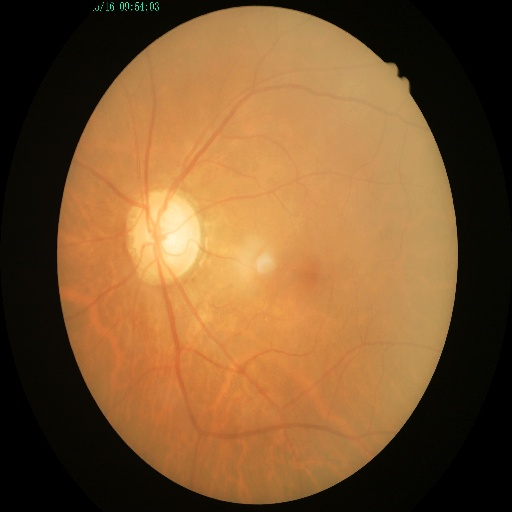

In [ ]:
#Import library
from IPython import display
display.Image(filename='./dataset/glaucoma/1495_left.jpg', width=200, height=150)

In [ ]:
# calculate image pixel mean, min, max

mean = pixels.mean()
print('Mean: %.3f' % mean)
# confirm pixel range is 0-255
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Mean: 86.173
Min: 0.000, Max: 255.000


### **Image hashing**

**To identify any duplicate images**


In [ ]:
import os
import glob
import hashlib
import pandas as pd

def img_hash(images, dir):
    hash_list = []  # list of tuples (filename, hash)
    for image in images:
        with open(image, "rb") as f:
            hash = hashlib.blake2b(f.read()).hexdigest()  # extract hash code
            filename = os.path.basename(image)  # extract subdirectory and filename
            dir_filename = os.path.join(dir, filename)
            hash_list.append((dir_filename, hash))
    hash_df = pd.DataFrame(hash_list, columns=['filename', 'hash'])  # dataframe of filenames & hashes
    return hash_df

In [ ]:
# hash cataract images
cataract_imgs = glob.glob("./dataset/cataract/*.*")
print(img_hash(images=cataract_imgs, dir='cataract')[:3])  # print first three rows of the DataFrame
# assign object to list
cataract_hashdf = img_hash(images=cataract_imgs, dir='cataract')

                    filename  \
0   cataract/_28_8675632.jpg   
1      cataract/611_left.jpg   
2  cataract/_114_5711178.jpg   

                                                hash  
0  62ab06d55acb26109cab58840137abd1288898fa3b0644...  
1  c710d2b02d10f60058a09ad69ef8222e72100d9a4f6cb3...  
2  9c84ceb61957225bbbd171eb435985e2aa93c0746d03fe...  


In [ ]:
# hash diabetic retinopathy images
dre_imgs = glob.glob("./dataset/diabetic_retinopathy/*.*")
dre_hashdf = img_hash(images = dre_imgs, dir='dre')

In [ ]:
# hash glaucoma images
glaucoma_imgs = glob.glob("./dataset/glaucoma/*.*")
glaucoma_hashdf = img_hash(images = glaucoma_imgs, dir='glaucoma')

In [ ]:
# hash normal images
normal_imgs = glob.glob("./dataset/normal/*.*")
normal_hashdf = img_hash(images = normal_imgs, dir='normal')

In [ ]:
# join all the hash dataframes together
hash_df = pd.concat([cataract_hashdf, dre_hashdf, glaucoma_hashdf, normal_hashdf], ignore_index=True)
# check hash_list count # should be 4217
len(hash_df)

4217

## **Search for duplicate hash codes:**

In [ ]:
duplicate_hashes = hash_df[hash_df.duplicated('hash', keep=False)] # based on hash codes only
print("Duplicate images based on hashcodes:")
print(duplicate_hashes) # 2 duplicate hashes.

Duplicate images based on hashcodes:
                     filename  \
327   cataract/1415_right.jpg   
704     cataract/625_left.jpg   
2461  glaucoma/1415_right.jpg   
2818    glaucoma/625_left.jpg   

                                                   hash  
327   a029f6e63fa8919142ac8a4c024caf81db515aa44bf4a7...  
704   9b41fcbbbdd4a1429f16d915f026d87f7a94f9a77eb3ef...  
2461  a029f6e63fa8919142ac8a4c024caf81db515aa44bf4a7...  
2818  9b41fcbbbdd4a1429f16d915f026d87f7a94f9a77eb3ef...  


## **Visualise preprocessed images**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__) #2.8.2

2.13.0


**What happens after resizing and rescaling:**

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(160,160) ,  # needs to be symmetrical
    layers.Rescaling(1./255) # desired height, width in model pipeline
])

result = resize_and_rescale(pixels)
print(result.shape) # new shape, channels

(160, 160, 3)


**What happens to image pixel values after rescaling:**

In [ ]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


**Show images before and after preprocessing:**

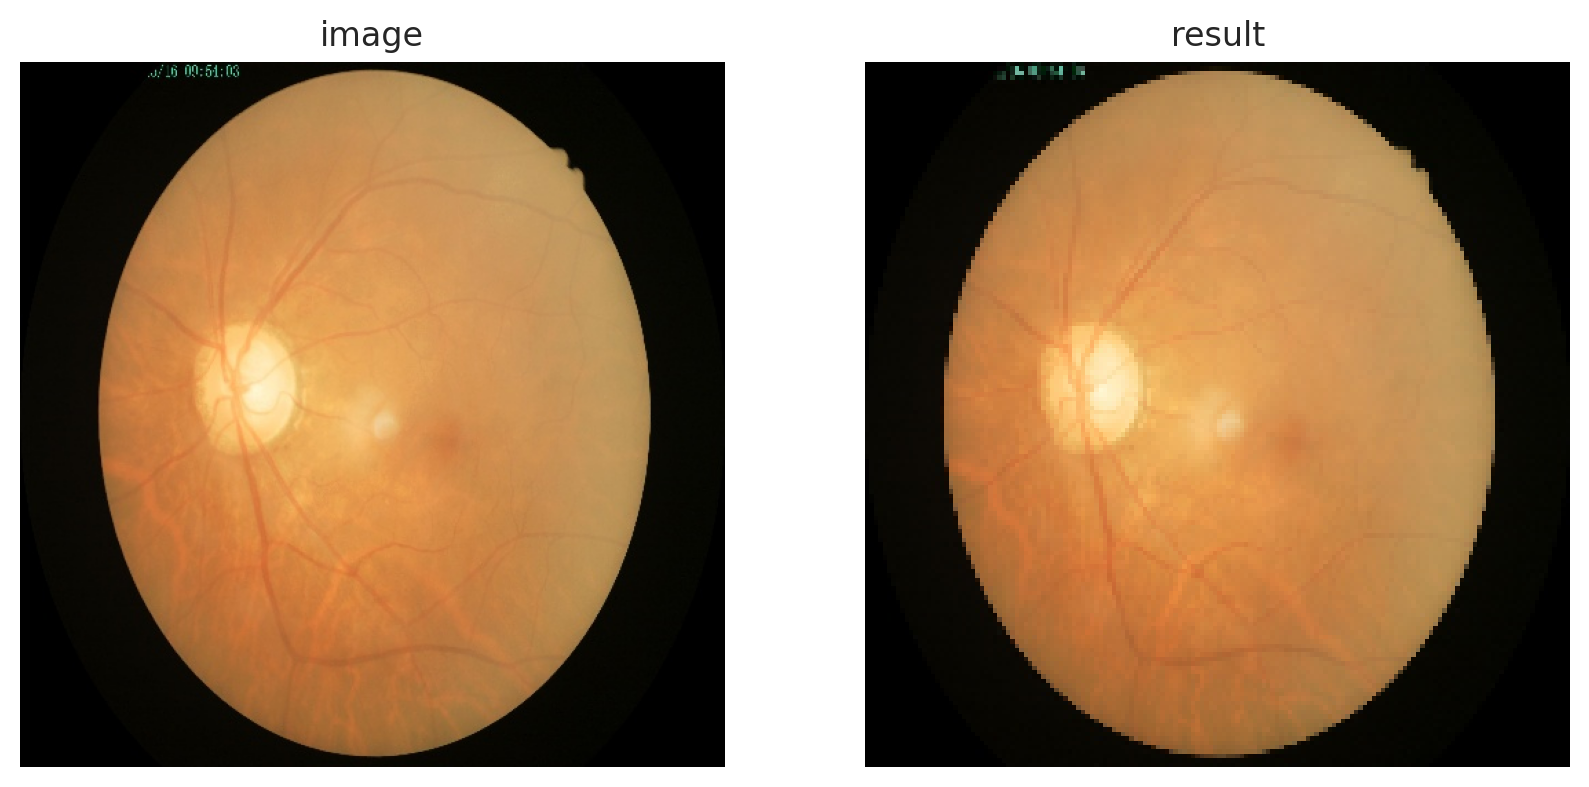

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,8))
ax0.imshow(im)
ax0.axis('off')
ax0.set_title('image')
# after pixel normalisation
ax1.imshow(result)
ax1.axis('off')
ax1.set_title('result')
plt.show() # result seems to have slight blurring of image, but still good definition

## **Create train, validation and test datasets**

In [ ]:
!pip install split-folders

In [ ]:
# first allocate a test set using this library
import splitfolders

splitfolders.ratio('./dataset/', output="./work_directory/", seed=1, ratio=(.5,.25,.25))

Copying files: 4217 files [00:01, 3475.99 files/s]


In [ ]:
# generate dataset that can be used for machine learning
from tensorflow.keras.utils import image_dataset_from_directory

image_size = (160, 160) # very important to get this right, will determine model success
batch_size = 32

train_ds = image_dataset_from_directory(
    './work_directory/train',
    image_size=image_size,
    shuffle=False,
    seed=1,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = image_dataset_from_directory(
    './work_directory/val',
    image_size=image_size,
    shuffle=False,
    seed=1,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = image_dataset_from_directory( # for model evaluation later
    './work_directory/test',
    image_size=image_size,
    seed=1,
    shuffle=False,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 2108 files belonging to 4 classes.
Found 1052 files belonging to 4 classes.
Found 1057 files belonging to 4 classes.


In [ ]:
# preview of how images are labelled
class_names = train_ds.class_names
print(class_names)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


## **Visualise images and labels together**

In [ ]:
# visualise label format # one-hot encoded
for _, labels in train_ds.take(1):
  print(labels[0])
  print(tf.argmax(labels[0], axis=0))
  break

tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(0, shape=(), dtype=int64)


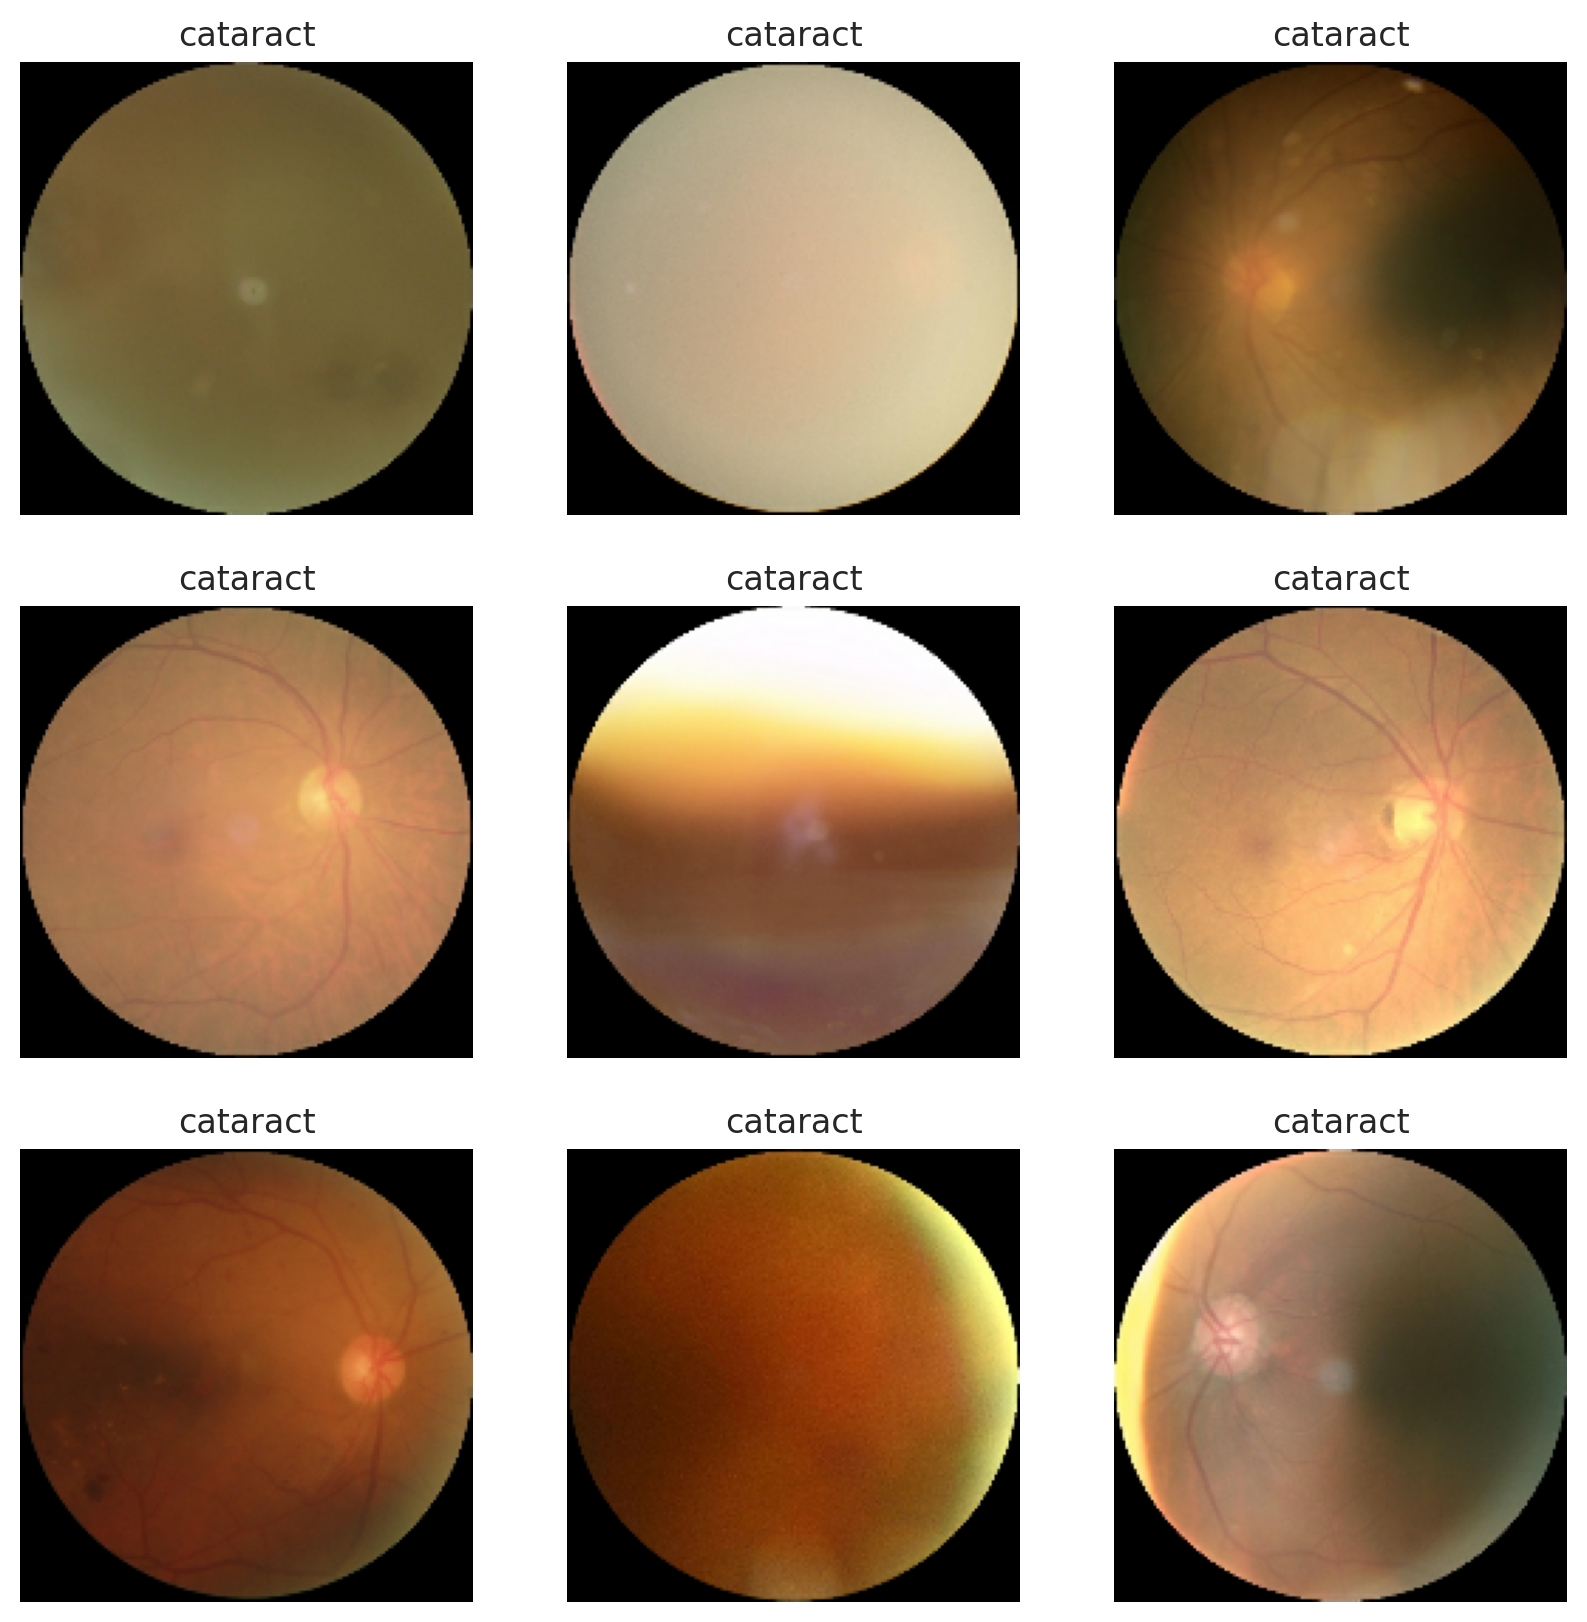

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # each image 160 x 160
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i], axis=0)])
    plt.axis("off")

## **Data augmentation**

In [ ]:
data_augmentation = tf.keras.Sequential(
    [ layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomContrast(0.1)
    ])

## **Visualise augmented images**

In [ ]:
def augmented_img():
  for image, _ in train_ds.take(1):  # take a sample image from training set
    plt.figure(figsize=(8, 8))
    first_image = image[0]
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
      plt.imshow(augmented_image[0] / 255) # rescale pixel 0 to 1
      plt.axis("off")

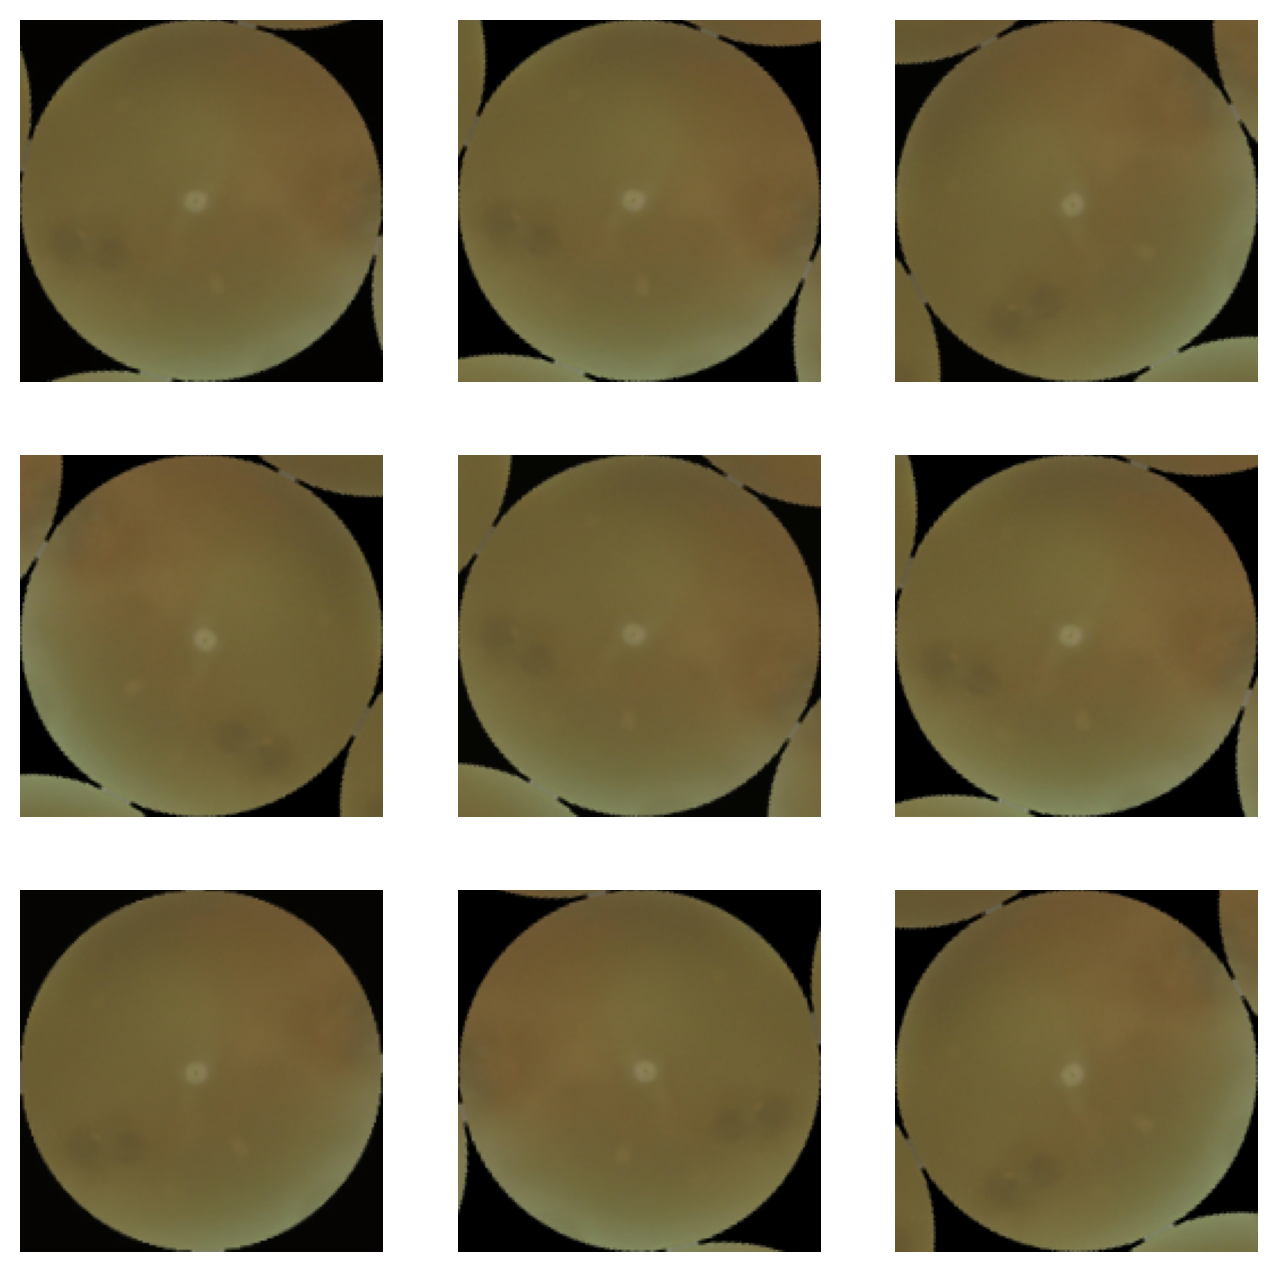

In [ ]:
augmented_img()

## **Create Base EfficientNet model**



In [ ]:
import keras.backend as K # function to add F1 score as metric

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      f1_score
]

In [ ]:
from tensorflow.keras.layers import (Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization)
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [ ]:
# Create the base model from the pre-trained model EfficientNet
def ENet():
  input_shape = (160, 160, 3)
  base_model = tf.keras.applications.EfficientNetV2S(input_shape=input_shape,
                                                     include_top=False,
                                                     weights='imagenet',
                                                     pooling='max')
  base_model.trainable=True # train entire model layers, yet with pre-trained weights from ImageNet
  x = base_model.output
  x = tf.keras.layers.Rescaling(1./255)(x)
  x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
  x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
  x=Dropout(rate=.4, seed=123)(x)
  output=Dense(4, activation='softmax')(x)
  model=Model(inputs=base_model.input, outputs=output)
  model.compile(tf.keras.optimizers.Adamax(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=METRICS)
  return model

model = ENet()

82420632/82420632 [==============================] - 1s 0us/step


## **Compile, fit model, run**

In [ ]:
# Train the model, doing validation at the end of each epoch.
epochs = 100

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("drive/MyDrive/Colab Notebooks/ENet_ep{epoch}_val{val_loss:.3f}", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,min_delta=0.001,restore_best_weights=True),
    tf.keras.callbacks.CSVLogger('drive/MyDrive/Colab Notebooks/ENet_history.csv'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3,verbose=1,mode='min',min_lr=0.00001)
]

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/100
66/66 [==============================] - 205s 2s/step - loss: 5.2786 - categorical_accuracy: 0.2097 - precision: 0.3251 - recall: 0.0560 - auc: 0.4930 - f1_score: 0.0683 - val_loss: 3.5044 - val_categorical_accuracy: 0.2462 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4976 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/100
66/66 [==============================] - 118s 2s/step - loss: 2.8305 - categorical_accuracy: 0.1618 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3665 - f1_score: 0.0000e+00 - val_loss: 2.3191 - val_categorical_accuracy: 0.2462 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4975 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/100
66/66 [==============================] - 106s 2s/step - loss: 2.0638 - categorical_accuracy: 0.3297 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4666 - f1_score: 0.0000e+00 - val_loss: 1.8576 - val_categorical_accuracy: 0.3032 - val_precision: 0.0000e+00 - val_recall: 0.00

## **Learning Curves**

In [ ]:
history = pd.read_csv('drive/MyDrive/Colab Notebooks/ENet_history.csv')
history.tail()

epoch       auc  categorical_accuracy  f1_score      loss  precision  \
30     30  0.962746              0.825901  0.661177  0.692121   0.886332   
31     31  0.966980              0.843928  0.677211  0.673763   0.894809   
32     32  0.969350              0.845825  0.711032  0.665545   0.914324   
33     33  0.969195              0.849621  0.700112  0.665600   0.902472   
34     34  0.969308              0.845351  0.699536  0.664228   0.893899   

      recall   val_auc  val_categorical_accuracy  val_f1_score  val_loss  \
30  0.602941  0.905473                  0.656844      0.610736  0.960840   
31  0.621442  0.906206                  0.654943      0.614139  0.956079   
32  0.648008  0.905700                  0.658745      0.611890  0.957025   
33  0.640892  0.905184                  0.659696      0.614051  0.957290   
34  0.639469  0.905662                  0.662548      0.615530  0.955441   

    val_precision  val_recall  
30       0.791956    0.542776  
31       0.787671    0.546578  
32       0.785714    0.543726  
33       0.784447    0.546578  
34       0.780785    0.548479

In [ ]:
acc = history['categorical_accuracy']
val_acc = history['val_categorical_accuracy']

loss = history['loss']
val_loss = history['val_loss']

In [ ]:
def learning_curves(acc,val_acc,loss,val_loss):
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),max(plt.ylim())])
  plt.xlim([0,max(plt.xlim())])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([min(plt.ylim()),max(plt.ylim())])
  plt.xlim([0,max(plt.xlim())])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()
  return plt.show()

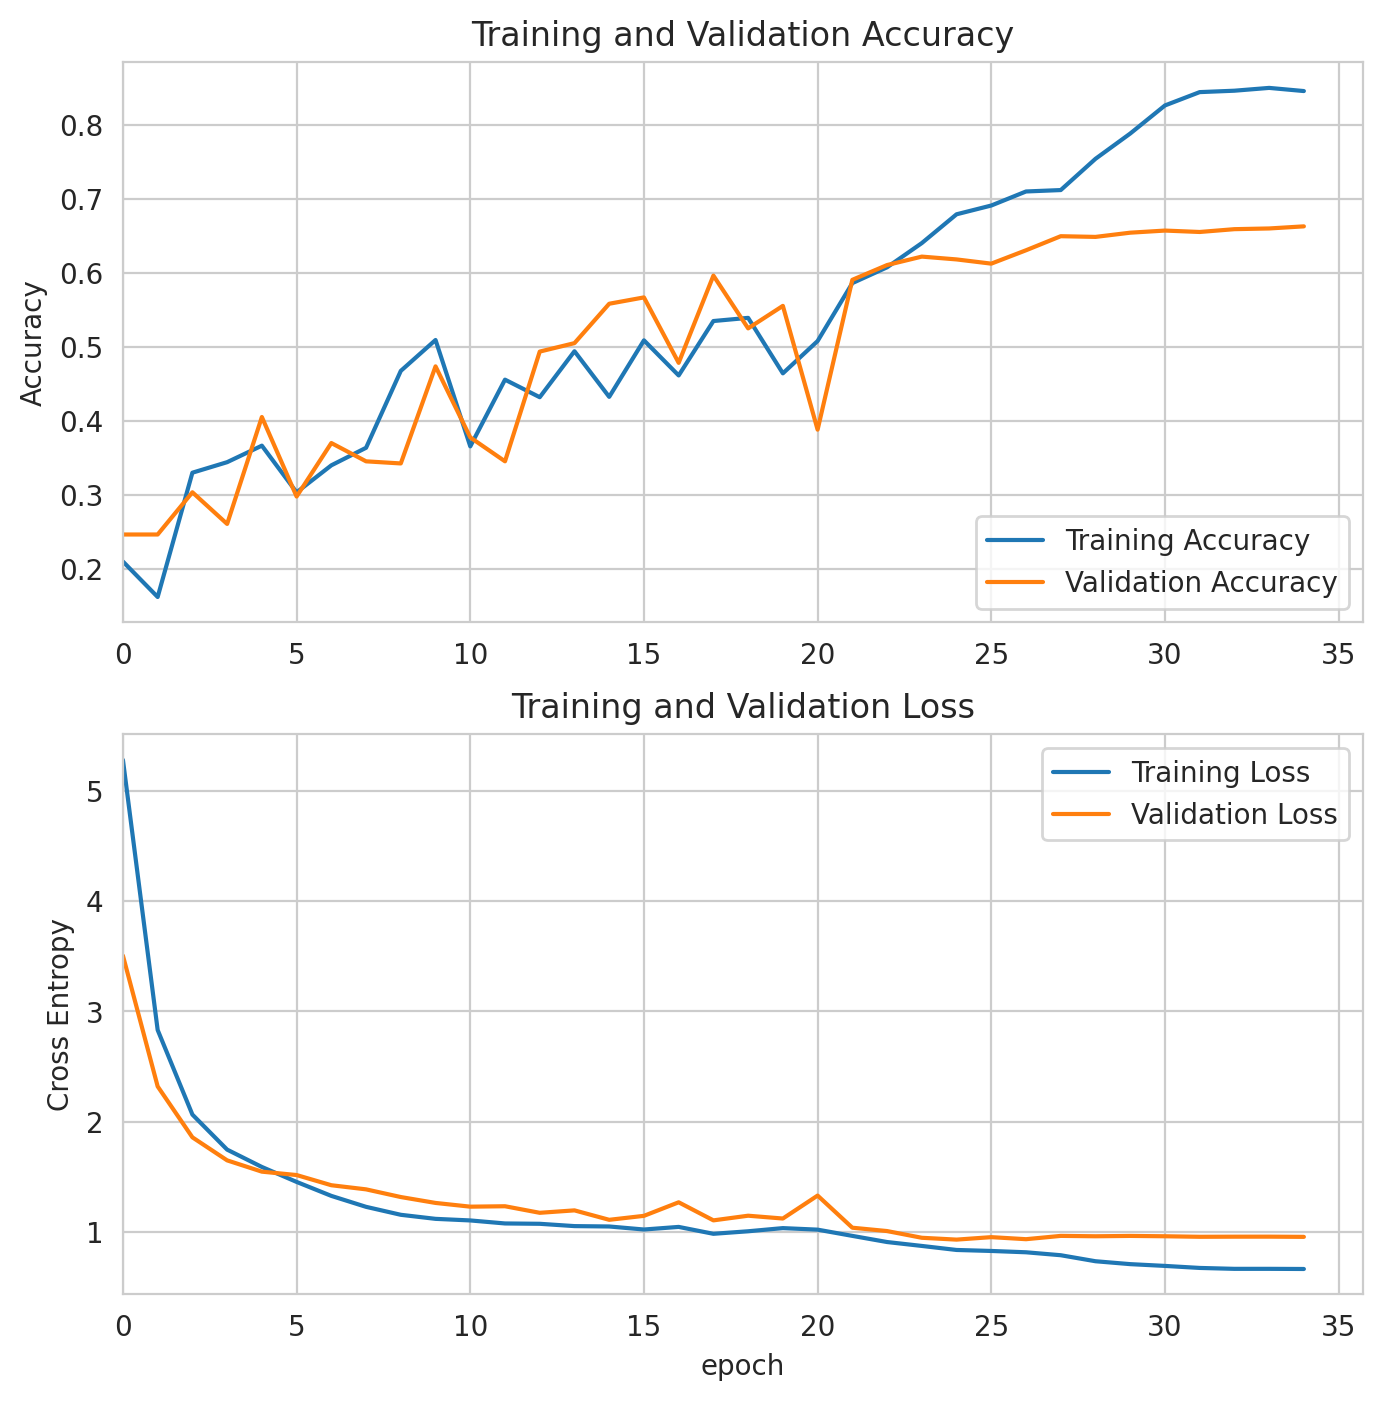

In [ ]:
learning_curves(acc,val_acc,loss,val_loss)

In [ ]:
def metrics(epoch_num):
  val_auc = history.loc[history['epoch']==epoch_num, ['val_auc']].values[0][0]
  auc = history.loc[history['epoch']==epoch_num, ['auc']].values[0][0]
  auc_diff = (auc - val_auc)*100 / auc
  print('AUC percentage difference is:', abs(auc_diff), '%')

  val_acc = history.loc[history['epoch']==epoch_num, ['val_categorical_accuracy']].values[0][0]
  acc = history.loc[history['epoch']==epoch_num, ['categorical_accuracy']].values[0][0]
  acc_diff = (acc - val_acc)*100 / acc
  print()
  print('Accuracy percentage difference is:', abs(acc_diff), '%')

In [ ]:
history.tail()

epoch       auc  categorical_accuracy  f1_score      loss  precision  \
30     30  0.962746              0.825901  0.661177  0.692121   0.886332   
31     31  0.966980              0.843928  0.677211  0.673763   0.894809   
32     32  0.969350              0.845825  0.711032  0.665545   0.914324   
33     33  0.969195              0.849621  0.700112  0.665600   0.902472   
34     34  0.969308              0.845351  0.699536  0.664228   0.893899   

      recall   val_auc  val_categorical_accuracy  val_f1_score  val_loss  \
30  0.602941  0.905473                  0.656844      0.610736  0.960840   
31  0.621442  0.906206                  0.654943      0.614139  0.956079   
32  0.648008  0.905700                  0.658745      0.611890  0.957025   
33  0.640892  0.905184                  0.659696      0.614051  0.957290   
34  0.639469  0.905662                  0.662548      0.615530  0.955441   

    val_precision  val_recall  
30       0.791956    0.542776  
31       0.787671    0.546578  
32       0.785714    0.543726  
33       0.784447    0.546578  
34       0.780785    0.548479

In [ ]:
# best epoch if based solely on best validation loss
metrics(epoch_num=34) # record epoch 35 as 34

AUC percentage difference is: 6.566051449719387 %

Accuracy percentage difference is: 21.624568125095497 %


Best base EfficientNet model (**epoch 34**) has the following validation metrics:

| Name               |   Scores   |
|:-------------------|:----------:|
|AUC                 |0.969308|
|Categorical Accuracy|0.845351|
|F1 score            |0.699536|
|Loss                |0.664228|
|Precision           |0.893899|
|Recall              |0.639469|


## **EfficientNet-L2 model with augmentation layers**

**Adding data augmentation layers, try running EfficientNet with data augmentation layers, and see if can get better performance, yet still maintain model generalisation...**

In [ ]:
input_shape = (160, 160, 3)
base_model = tf.keras.applications.EfficientNetV2S(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet',
                                                   pooling='max')
base_model.trainable=True # train entire model layers, yet with pre-trained weights from ImageNet

In [ ]:
# Create the augmented model from the pre-trained model EfficientNet
def ENet_a():
  inputs = tf.keras.Input(shape=(160, 160, 3))
  x = data_augmentation(inputs)
  x = tf.keras.layers.Rescaling(1./255)(x) # rescaling layer
  x = base_model(x, training=True)
  x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
  x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
  x=Dropout(rate=.4, seed=123)(x)
  output=Dense(4, activation='softmax')(x)
  model=Model(inputs=inputs, outputs=output)
  model.compile(tf.keras.optimizers.Adamax(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=METRICS)
  return model

model_a = ENet_a()

## **Fit model and run**

In [ ]:
# Train the model, doing validation at the end of each epoch.
epochs = 100

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("drive/MyDrive/Colab Notebooks/ENet-a_ep{epoch}_val{val_loss:.3f}", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,min_delta=0.001,restore_best_weights=True),
    tf.keras.callbacks.CSVLogger('drive/MyDrive/Colab Notebooks/ENet-a_history.csv'), # save history
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3,verbose=1,mode='min',min_lr=0.00001)
]

history_a = model_a.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/150
66/66 [==============================] - 190s 2s/step - loss: 8.5968 - categorical_accuracy: 0.6383 - precision: 0.6916 - recall: 0.5813 - auc: 0.8315 - f1_score: 0.6231 - val_loss: 14.8266 - val_categorical_accuracy: 0.2557 - val_precision: 0.2607 - val_recall: 0.1977 - val_auc: 0.5139 - val_f1_score: 0.2212 - lr: 0.0010
Epoch 2/150
66/66 [==============================] - 107s 2s/step - loss: 8.5640 - categorical_accuracy: 0.3857 - precision: 0.3992 - recall: 0.3458 - auc: 0.6425 - f1_score: 0.3718 - val_loss: 7.3924 - val_categorical_accuracy: 0.2490 - val_precision: 0.2544 - val_recall: 0.1226 - val_auc: 0.4882 - val_f1_score: 0.1687 - lr: 0.0010
Epoch 3/150
66/66 [==============================] - 27s 410ms/step - loss: 7.5128 - categorical_accuracy: 0.5133 - precision: 0.5291 - recall: 0.4696 - auc: 0.7411 - f1_score: 0.4985 - val_loss: 7.5376 - val_categorical_accuracy: 0.2595 - val_precision: 0.2467 - val_recall: 0.1587 - val_auc: 0.4977 - val_f1_score: 0.1994 - lr:

## **Another Model**

In [ ]:
input_shape = (160, 160, 3)
base_model = tf.keras.applications.EfficientNetV2S(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet',
                                                   pooling='max')
base_model.trainable=True # train entire model layers, yet with pre-trained weights from ImageNet

82420632/82420632 [==============================] - 4s 0us/step


In [ ]:
# Create the augmented model from the pre-trained model EfficientNet
def ENet_a():
  inputs = tf.keras.Input(shape=(160, 160, 3))
  x = data_augmentation(inputs)
  x = tf.keras.layers.Rescaling(1./255)(x) # rescaling layer
  x = base_model(x, training=True)
  x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
  x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
  x=Dropout(rate=.4, seed=123)(x)
  output=Dense(4, activation='softmax')(x)
  model=Model(inputs=inputs, outputs=output)
  model.compile(tf.keras.optimizers.Adamax(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=METRICS)
  return model

model_a = ENet_a()

In [ ]:
# Train the model, doing validation at the end of each epoch.
epochs = 200

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("drive/MyDrive/Colab Notebooks/EfficientNet/EfficientNet_ep{epoch}_val{val_loss:.3f}", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,min_delta=0.001,restore_best_weights=True),
    tf.keras.callbacks.CSVLogger('drive/MyDrive/Colab Notebooks/EfficientNet/EfficientNet_history.csv'), # save history
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3,verbose=1,mode='min',min_lr=0.00001)
]

history_a = model_a.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/200
66/66 [==============================] - 176s 1s/step - loss: 9.1087 - categorical_accuracy: 0.4364 - precision: 0.4560 - recall: 0.3838 - auc: 0.6787 - f1_score: 0.4176 - val_loss: 10.9227 - val_categorical_accuracy: 0.2510 - val_precision: 0.2522 - val_recall: 0.2452 - val_auc: 0.5122 - val_f1_score: 0.2494 - lr: 0.0010
Epoch 2/200
66/66 [==============================] - 10s 154ms/step - loss: 8.0006 - categorical_accuracy: 0.4194 - precision: 0.4432 - recall: 0.3795 - auc: 0.6769 - f1_score: 0.4077 - val_loss: 13.9442 - val_categorical_accuracy: 0.2538 - val_precision: 0.2537 - val_recall: 0.2433 - val_auc: 0.5114 - val_f1_score: 0.2509 - lr: 0.0010
Epoch 3/200
66/66 [==============================] - 84s 1s/step - loss: 7.5348 - categorical_accuracy: 0.4227 - precision: 0.4479 - recall: 0.3733 - auc: 0.6777 - f1_score: 0.4048 - val_loss: 7.6804 - val_categorical_accuracy: 0.2481 - val_precision: 0.2585 - val_recall: 0.2234 - val_auc: 0.4958 - val_f1_score: 0.2404 - lr:

## **Learning Curves**

In [ ]:
import pandas as pd
history = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/EfficientNet/EfficientNet_history.csv')
history.head(3)

epoch       auc  categorical_accuracy  f1_score      loss  precision  \
0      0  0.678742              0.436433  0.417624  9.108743   0.456032   
1      1  0.676868              0.419355  0.407677  8.000576   0.443213   
2      2  0.677715              0.422676  0.404751  7.534808   0.447923   

     recall   val_auc  val_categorical_accuracy  val_f1_score   val_loss  \
0  0.383776  0.512158                  0.250951      0.249444  10.922715   
1  0.379507  0.511363                  0.253802      0.250894  13.944161   
2  0.373340  0.495837                  0.248099      0.240417   7.680424   

   val_precision  val_recall  
0       0.252199    0.245247  
1       0.253717    0.243346  
2       0.258526    0.223384

In [ ]:
acc = history['categorical_accuracy']
val_acc = history['val_categorical_accuracy']

loss = history['loss']
val_loss = history['val_loss']

In [ ]:
def learning_curves(acc,val_acc,loss,val_loss):
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),max(plt.ylim())])
  plt.xlim([0,max(plt.xlim())])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([min(plt.ylim()),max(plt.ylim())])
  plt.xlim([0,max(plt.xlim())])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()
  return plt.show()

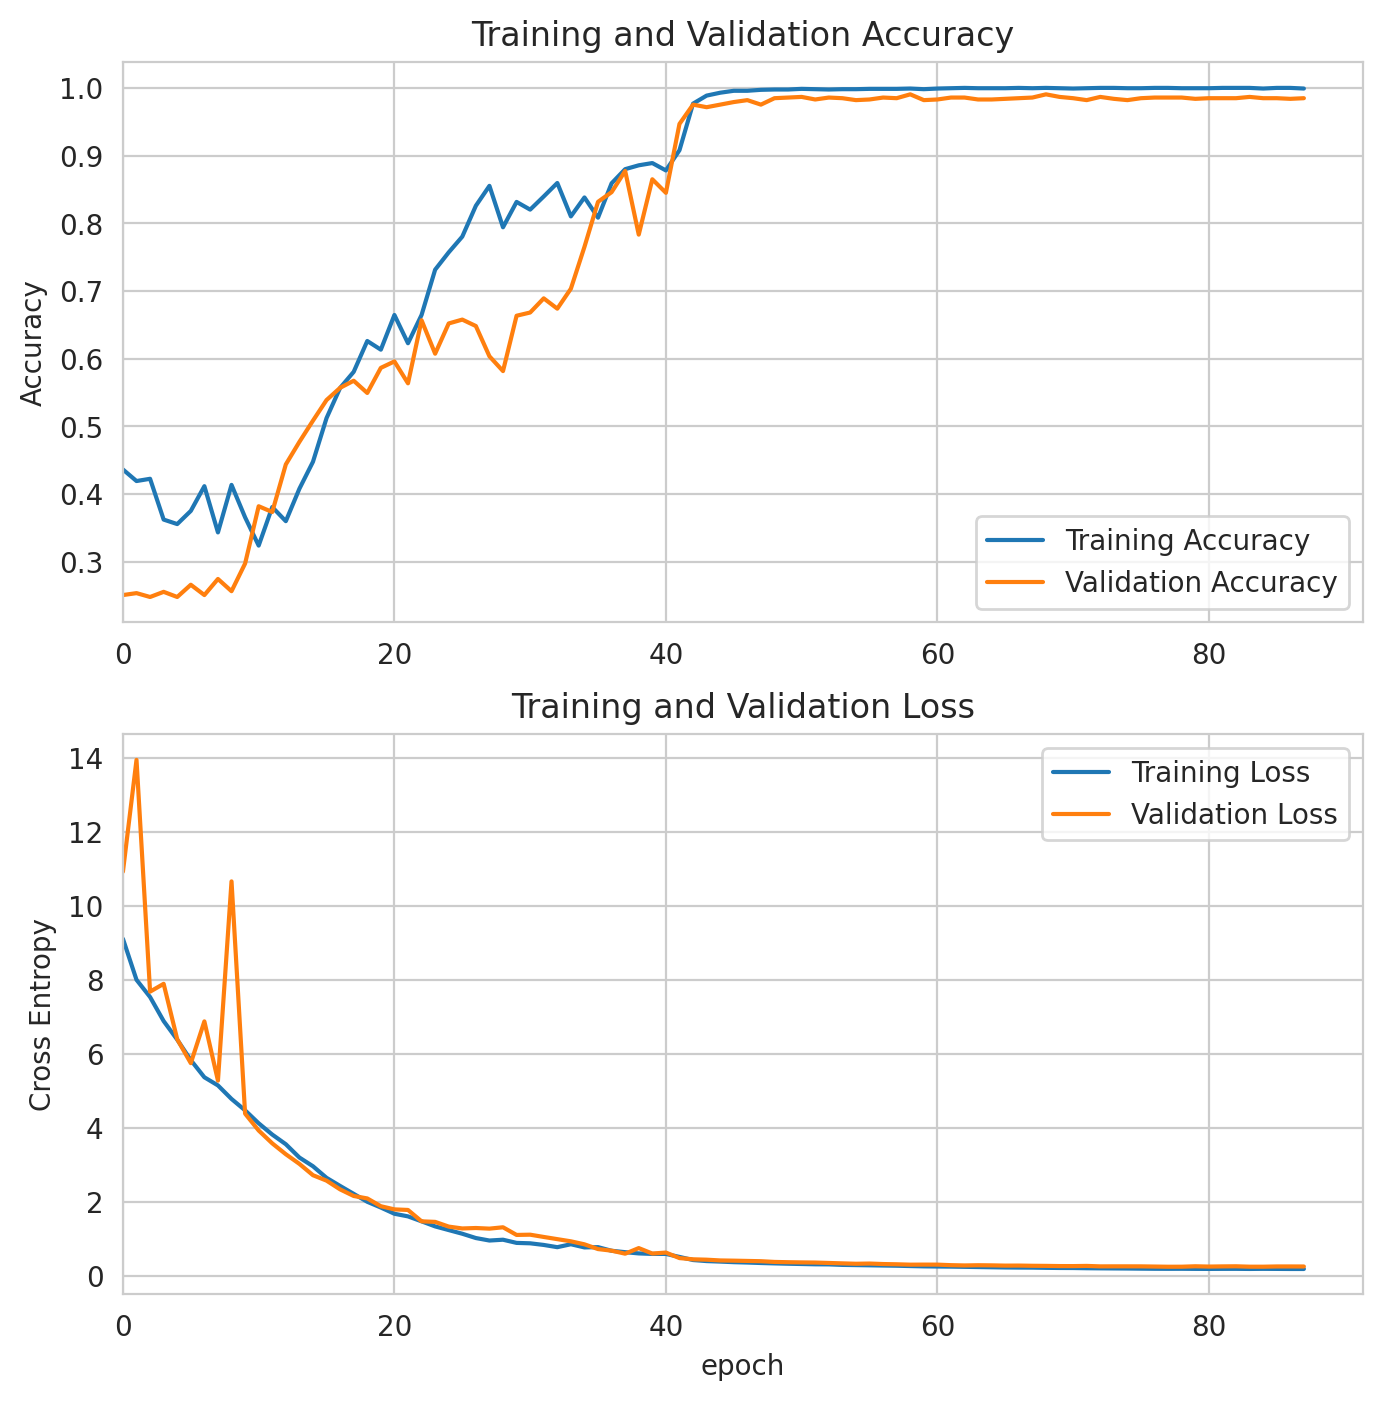

In [ ]:
learning_curves(acc,val_acc,loss,val_loss)

In [ ]:
def metrics(epoch_num):
  val_auc = history.loc[history['epoch']==epoch_num, ['val_auc']].values[0][0]
  auc = history.loc[history['epoch']==epoch_num, ['auc']].values[0][0]
  auc_diff = (auc - val_auc)*100 / auc
  print('AUC percentage difference is:', abs(auc_diff), '%')

  val_acc = history.loc[history['epoch']==epoch_num, ['val_categorical_accuracy']].values[0][0]
  acc = history.loc[history['epoch']==epoch_num, ['categorical_accuracy']].values[0][0]
  acc_diff = (acc - val_acc)*100 / acc
  print()
  print('Accuracy percentage difference is:', abs(acc_diff), '%')

In [ ]:
# check for generalisation using epoch 78
metrics(epoch_num=77)

AUC percentage difference is: 0.07661581952760452 %

Accuracy percentage difference is: 1.425856351852417 %


Adding data augmentation layers to the EfficientNet model resulted in model requiring more epochs to learn, but achieve slightly better generalisation. Using model at **epoch 78**, the validation metrics are as follows:

| Name               |   Scores   |
|:-------------------|:----------:|
|**AUC**                 |**1.0000**|
|**Categorical Accuracy**|**1.0000**|
|**F1 score**            |**0.9995**|
|**Loss**                |**0.1888**|
|**Precision**           |**1.0000**|
|**Recall**              |**0.9991**|


## **Evaluation**


In [ ]:
# choose model for evaluation
# load model
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/EfficientNet/EfficientNet_ep78_val0.245",
                                   custom_objects={'f1_score': f1_score})

### **Confusion matrix**


In [ ]:
# get predictions for confusion matrix
# class_names = train_ds.class_names # from previous cell
print(class_names)

print('===== test_ds predictions =====')
test_preds = model.predict(test_ds, verbose=1) # get test_ds predictions
# sample test_ds predictions
print(test_preds[2])
for array in [test_preds[2]]:
  print(f'{class_names[0]} probability is: {array[0]:.4f}')
  print(f'{class_names[1]} probability is: {array[1]:.4f}')
  print(f'{class_names[2]} probability is: {array[2]:.4f}')
  print(f'{class_names[3]} probability is: {array[3]:.4f}')
  break

print() #gap

print('===== train_ds predictions =====')
train_preds = model.predict(train_ds, verbose=1) # get train_ds predictions
# sample train_ds predictions
print(train_preds[:1])
for array in train_preds:
  print(f'{class_names[0]} probability is: {array[0]:.4f}')
  print(f'{class_names[1]} probability is: {array[1]:.4f}')
  print(f'{class_names[2]} probability is: {array[2]:.4f}')
  print(f'{class_names[3]} probability is: {array[3]:.4f}')
  break

print() #gap

print('===== val_ds predictions =====')
val_preds = model.predict(val_ds, verbose=1) # get val_ds predictions
# sample val_ds predictions
print(val_preds[:1])
for array in val_preds:
  print(f'{class_names[0]} probability is: {array[0]:.4f}')
  print(f'{class_names[1]} probability is: {array[1]:.4f}')
  print(f'{class_names[2]} probability is: {array[2]:.4f}')
  print(f'{class_names[3]} probability is: {array[3]:.4f}')
  break

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
===== test_ds predictions =====
34/34 [==============================] - 7s 66ms/step
[0.76116586 0.03614601 0.15027234 0.05241576]
cataract probability is: 0.7612
diabetic_retinopathy probability is: 0.0361
glaucoma probability is: 0.1503
normal probability is: 0.0524

===== train_ds predictions =====
66/66 [==============================] - 4s 56ms/step
[[0.9616345  0.00892755 0.01775066 0.01168725]]
cataract probability is: 0.9616
diabetic_retinopathy probability is: 0.0089
glaucoma probability is: 0.0178
normal probability is: 0.0117

===== val_ds predictions =====
33/33 [==============================] - 2s 50ms/step
[[0.97858334 0.00454072 0.0099265  0.0069494 ]]
cataract probability is: 0.9786
diabetic_retinopathy probability is: 0.0045
glaucoma probability is: 0.0099
normal probability is: 0.0069


In [ ]:
y_pred_probs = np.max(test_preds, axis=-1) # store probabilities of predictions for later use

In [ ]:
y_proba = test_preds # store all probabilities for later use in ROC curve
print(y_proba[:, 0][:3]) # predicted probability of cataract

[0.8047474  0.838243   0.76116586]


#####**OHE predictions:**

In [ ]:
# convert prediction probabilities into ohe
# for confusion matrix

# for test_ds
idx = np.argmax(test_preds, axis=-1)
test_preds = np.zeros( test_preds.shape )
test_preds[ np.arange(test_preds.shape[0]), idx] = 1

#print(train_preds.argmax(axis=1))
#print(train_labels.argmax(axis=1))

# for train_ds
idx = np.argmax(train_preds, axis=-1)
train_preds = np.zeros( train_preds.shape )
train_preds[ np.arange(train_preds.shape[0]), idx] = 1

# for val_ds
idx = np.argmax(val_preds, axis=-1)
val_preds = np.zeros( val_preds.shape )
val_preds[ np.arange(val_preds.shape[0]), idx] = 1

print('Predicted test_ds labels:', test_preds[:5])
print() # gap
print('Predicted train_ds labels:', train_preds[:5])
print() # gap
print('Predicted val_ds labels:', val_preds[:5])

Predicted test_ds labels: [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]

Predicted train_ds labels: [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]

Predicted val_ds labels: [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


##### **Extracting true labels:**

In [ ]:
# extract true labels and images from test_ds
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
test_images = np.concatenate([x for x, y in test_ds], axis=0)

# extract true labels and images from train_ds
train_labels = np.concatenate([y for x, y in train_ds], axis=0)
train_images = np.concatenate([x for x, y in train_ds], axis=0)

# extract true labels and images from val_ds
val_labels = np.concatenate([y for x, y in val_ds], axis=0)
val_images = np.concatenate([x for x, y in val_ds], axis=0)

print('===== Test set true labels =====')
print(test_labels[:5])
print() # gap
print('===== Train set true labels =====')
print(train_labels[:5])
print() # gap
print('===== Validation set true labels =====')
print(val_labels[:5])

===== Test set true labels =====
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]

===== Train set true labels =====
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]

===== Validation set true labels =====
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


##### **Plot confusion matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
# Creating a confusion matrix for test_ds predictions
test_cm = confusion_matrix(test_labels.argmax(axis=1), test_preds.argmax(axis=1))
# Creating a confusion matrix for train_ds predictions
train_cm = confusion_matrix(train_labels.argmax(axis=1), train_preds.argmax(axis=1))
# Creating a confusion matrix for val_ds predictions
val_cm = confusion_matrix(val_labels.argmax(axis=1), val_preds.argmax(axis=1))

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
test_cm_df = pd.DataFrame(test_cm,
                          index = class_names,
                          columns = class_names)
train_cm_df = pd.DataFrame(train_cm,
                           index = class_names,
                           columns = class_names)
val_cm_df = pd.DataFrame(val_cm,
                         index = class_names,
                         columns = class_names)

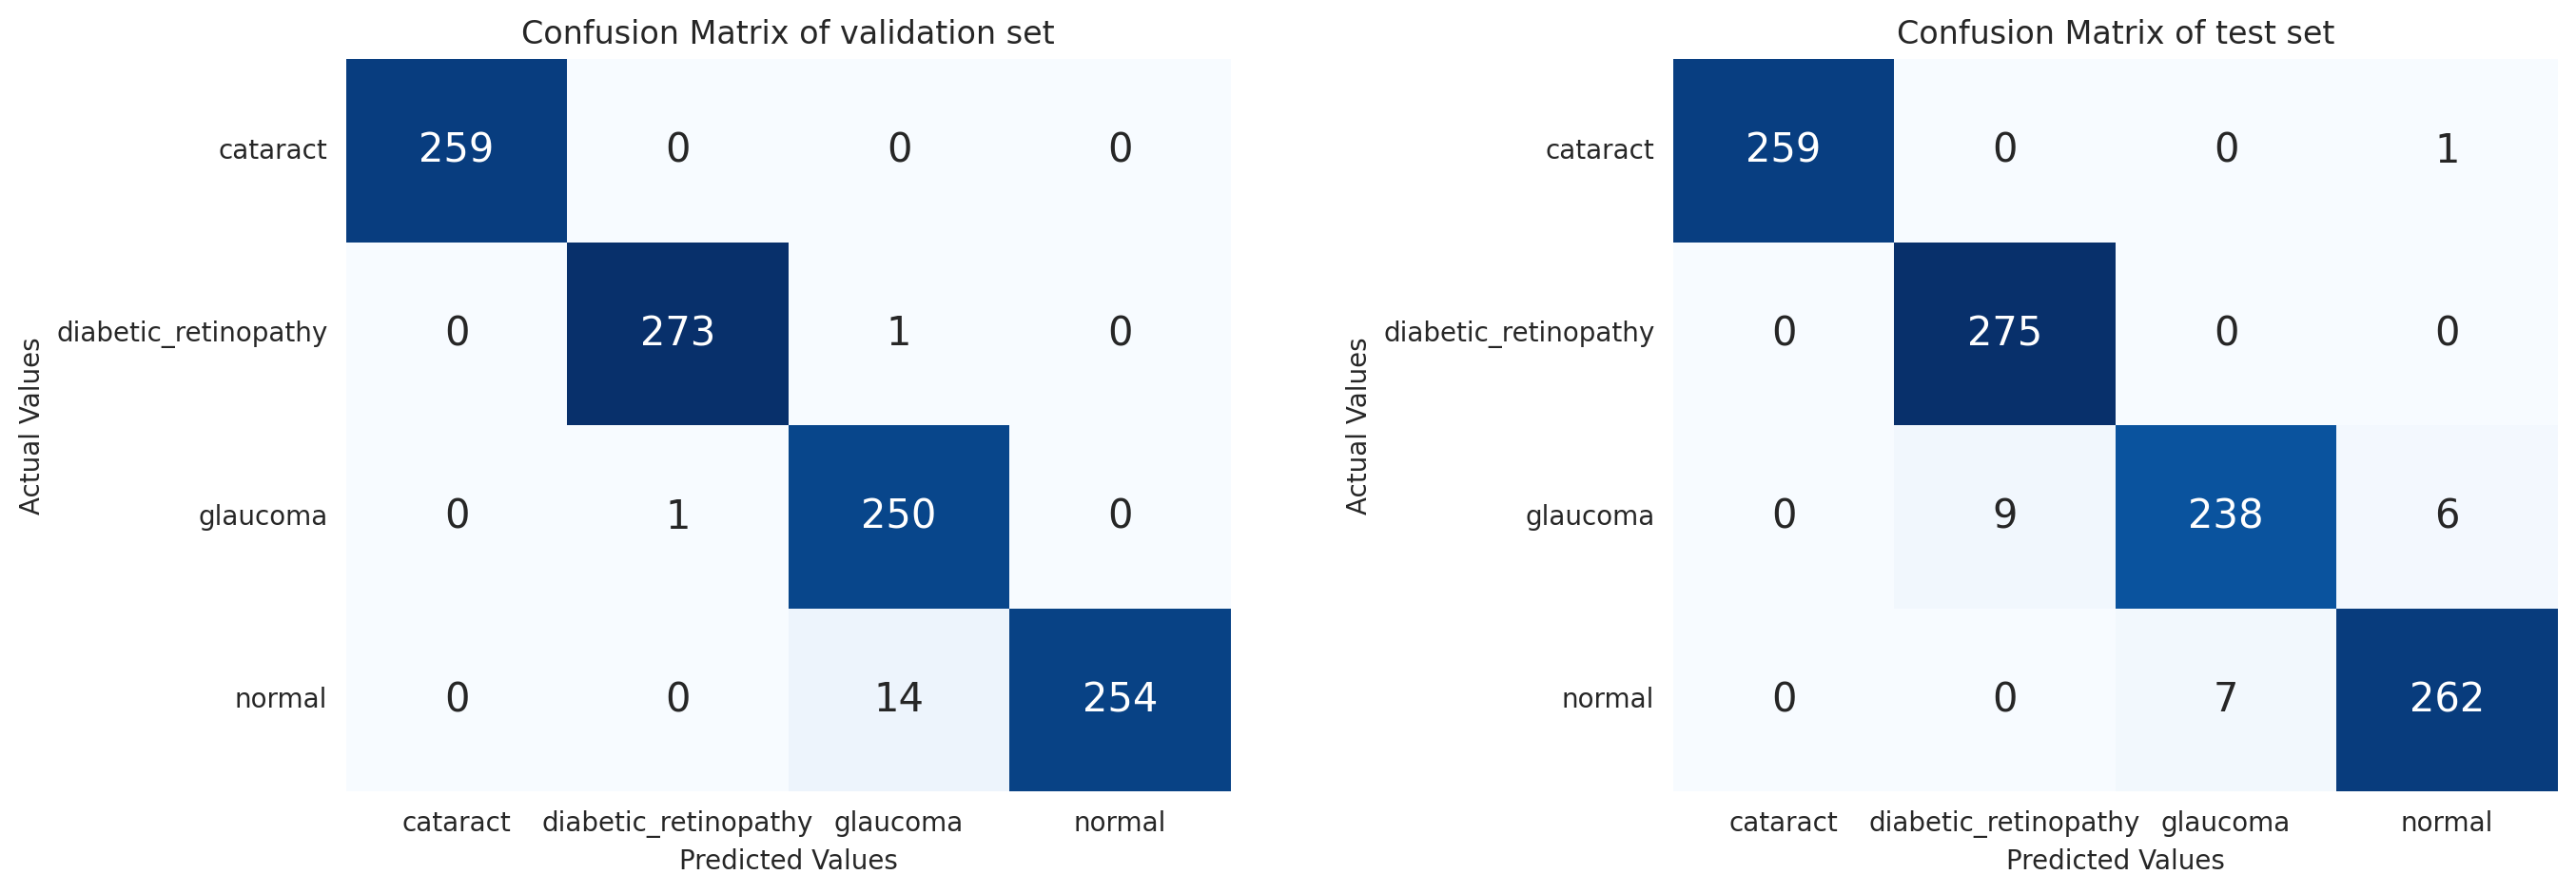

In [ ]:
#Plotting confusion matrices using heatmap
fig, axes = plt.subplots(1, 2, figsize=(15,5))
#sns.heatmap(train_cm_df, annot=True, cbar=False, cmap='Blues', vmin=0, fmt='.3g', annot_kws={"size": 15}, ax=axes[0])
#axes[0].set_title('Confusion Matrix of train set')
#axes[0].set_ylabel('Actual Values')
#axes[0].set_xlabel('Predicted Values')

sns.heatmap(val_cm_df, annot=True, cbar=False, cmap='Blues', vmin=0, fmt='.3g', annot_kws={"size": 15}, ax=axes[0])
axes[0].set_title('Confusion Matrix of validation set')
axes[0].set_ylabel('Actual Values')
axes[0].set_xlabel('Predicted Values')

sns.heatmap(test_cm_df, annot=True, cbar=False, cmap='Blues', vmin=0, fmt='.3g', annot_kws={"size": 15}, ax=axes[1])
axes[1].set_title('Confusion Matrix of test set')
axes[1].set_ylabel('Actual Values')
axes[1].set_xlabel('Predicted Values')

plt.subplots_adjust(wspace=0.5)

plt.show()

### **Classification report**

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, test_preds, target_names=class_names, digits= 4))

                      precision    recall  f1-score   support

            cataract     1.0000    0.9962    0.9981       260
diabetic_retinopathy     0.9683    1.0000    0.9839       275
            glaucoma     0.9714    0.9407    0.9558       253
              normal     0.9740    0.9740    0.9740       269

           micro avg     0.9782    0.9782    0.9782      1057
           macro avg     0.9784    0.9777    0.9779      1057
        weighted avg     0.9783    0.9782    0.9781      1057
         samples avg     0.9782    0.9782    0.9782      1057



## **Misclassified test images**

In [ ]:
# extract test file names from test_ds
# this cannot do with tensorflow datasets that are prefetched autotuned
test_filenames = test_ds.file_paths

In [ ]:
len(test_filenames)

1057

In [ ]:
class_names

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [ ]:
# convert OHE to interger version of class_names for easier comparison
y_true = tf.argmax(test_labels, axis=1).numpy() # tensor object not iterable, use numpy to convert to list
y_pred = tf.argmax(test_preds, axis=1).numpy()
print('First 5 true labels:', y_true[:5])
print('First 5 predictions:', y_pred[:5])

error_list = []

for a, b, c, d in zip(y_true, y_pred, y_pred_probs, test_filenames):
  if a != b:
    error_list.append((class_names[a],class_names[b],c,d))

First 5 true labels: [0 0 0 0 0]
First 5 predictions: [0 0 0 0 0]


In [ ]:
len(error_list)

23

In [ ]:
print('Prediction accuracy on test data:', 100 - (len(error_list)*100/len(test_filenames)), '%')

Prediction accuracy on test data: 97.8240302743614 %


### **Looking into specific images that were misclassified**

In [ ]:
error_list[:5] # check for duplicates

[('cataract',
  'normal',
  0.36466685,
  './work_directory/test/cataract/_208_168871.jpg'),
 ('glaucoma',
  'diabetic_retinopathy',
  0.89840174,
  './work_directory/test/glaucoma/1209_left.jpg'),
 ('glaucoma',
  'diabetic_retinopathy',
  0.9024515,
  './work_directory/test/glaucoma/1209_right.jpg'),
 ('glaucoma',
  'diabetic_retinopathy',
  0.799427,
  './work_directory/test/glaucoma/1211_right.jpg'),
 ('glaucoma',
  'diabetic_retinopathy',
  0.89219964,
  './work_directory/test/glaucoma/1213_right.jpg')]

In [ ]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



In [ ]:
import re

print ('Below is a list of test files that were misclassified \n')
msg='{0:^10}{1:^30s}{2:^20s}{3:^20s}{4:^15s}'.format('No.','Test File','True Label','Predicted as','Probability')
print_in_color(msg)

for i, (a, b, c, d) in enumerate(error_list):
  x = re.split('./work_directory/test/', d)[-1]
  print('{0:^10}{1:^30s}{2:^20s}{3:^20s}  {4:.4f}'.format(i+1,x,a,b,c))

Below is a list of test files that were misclassified 

   No.              Test File                True Label         Predicted as      Probability  

    1        cataract/_208_168871.jpg         cataract             normal         0.3647
    2         glaucoma/1209_left.jpg          glaucoma      diabetic_retinopathy  0.8984
    3        glaucoma/1209_right.jpg          glaucoma      diabetic_retinopathy  0.9025
    4        glaucoma/1211_right.jpg          glaucoma      diabetic_retinopathy  0.7994
    5        glaucoma/1213_right.jpg          glaucoma      diabetic_retinopathy  0.8922
    6        glaucoma/1215_right.jpg          glaucoma      diabetic_retinopathy  0.9018
    7        glaucoma/1216_right.jpg          glaucoma      diabetic_retinopathy  0.9008
    8         glaucoma/1218_left.jpg          glaucoma      diabetic_retinopathy  0.9512
    9         glaucoma/1221_left.jpg          glaucoma      diabetic_retinopathy  0.8824
    10       glaucoma/1221_right.jpg          

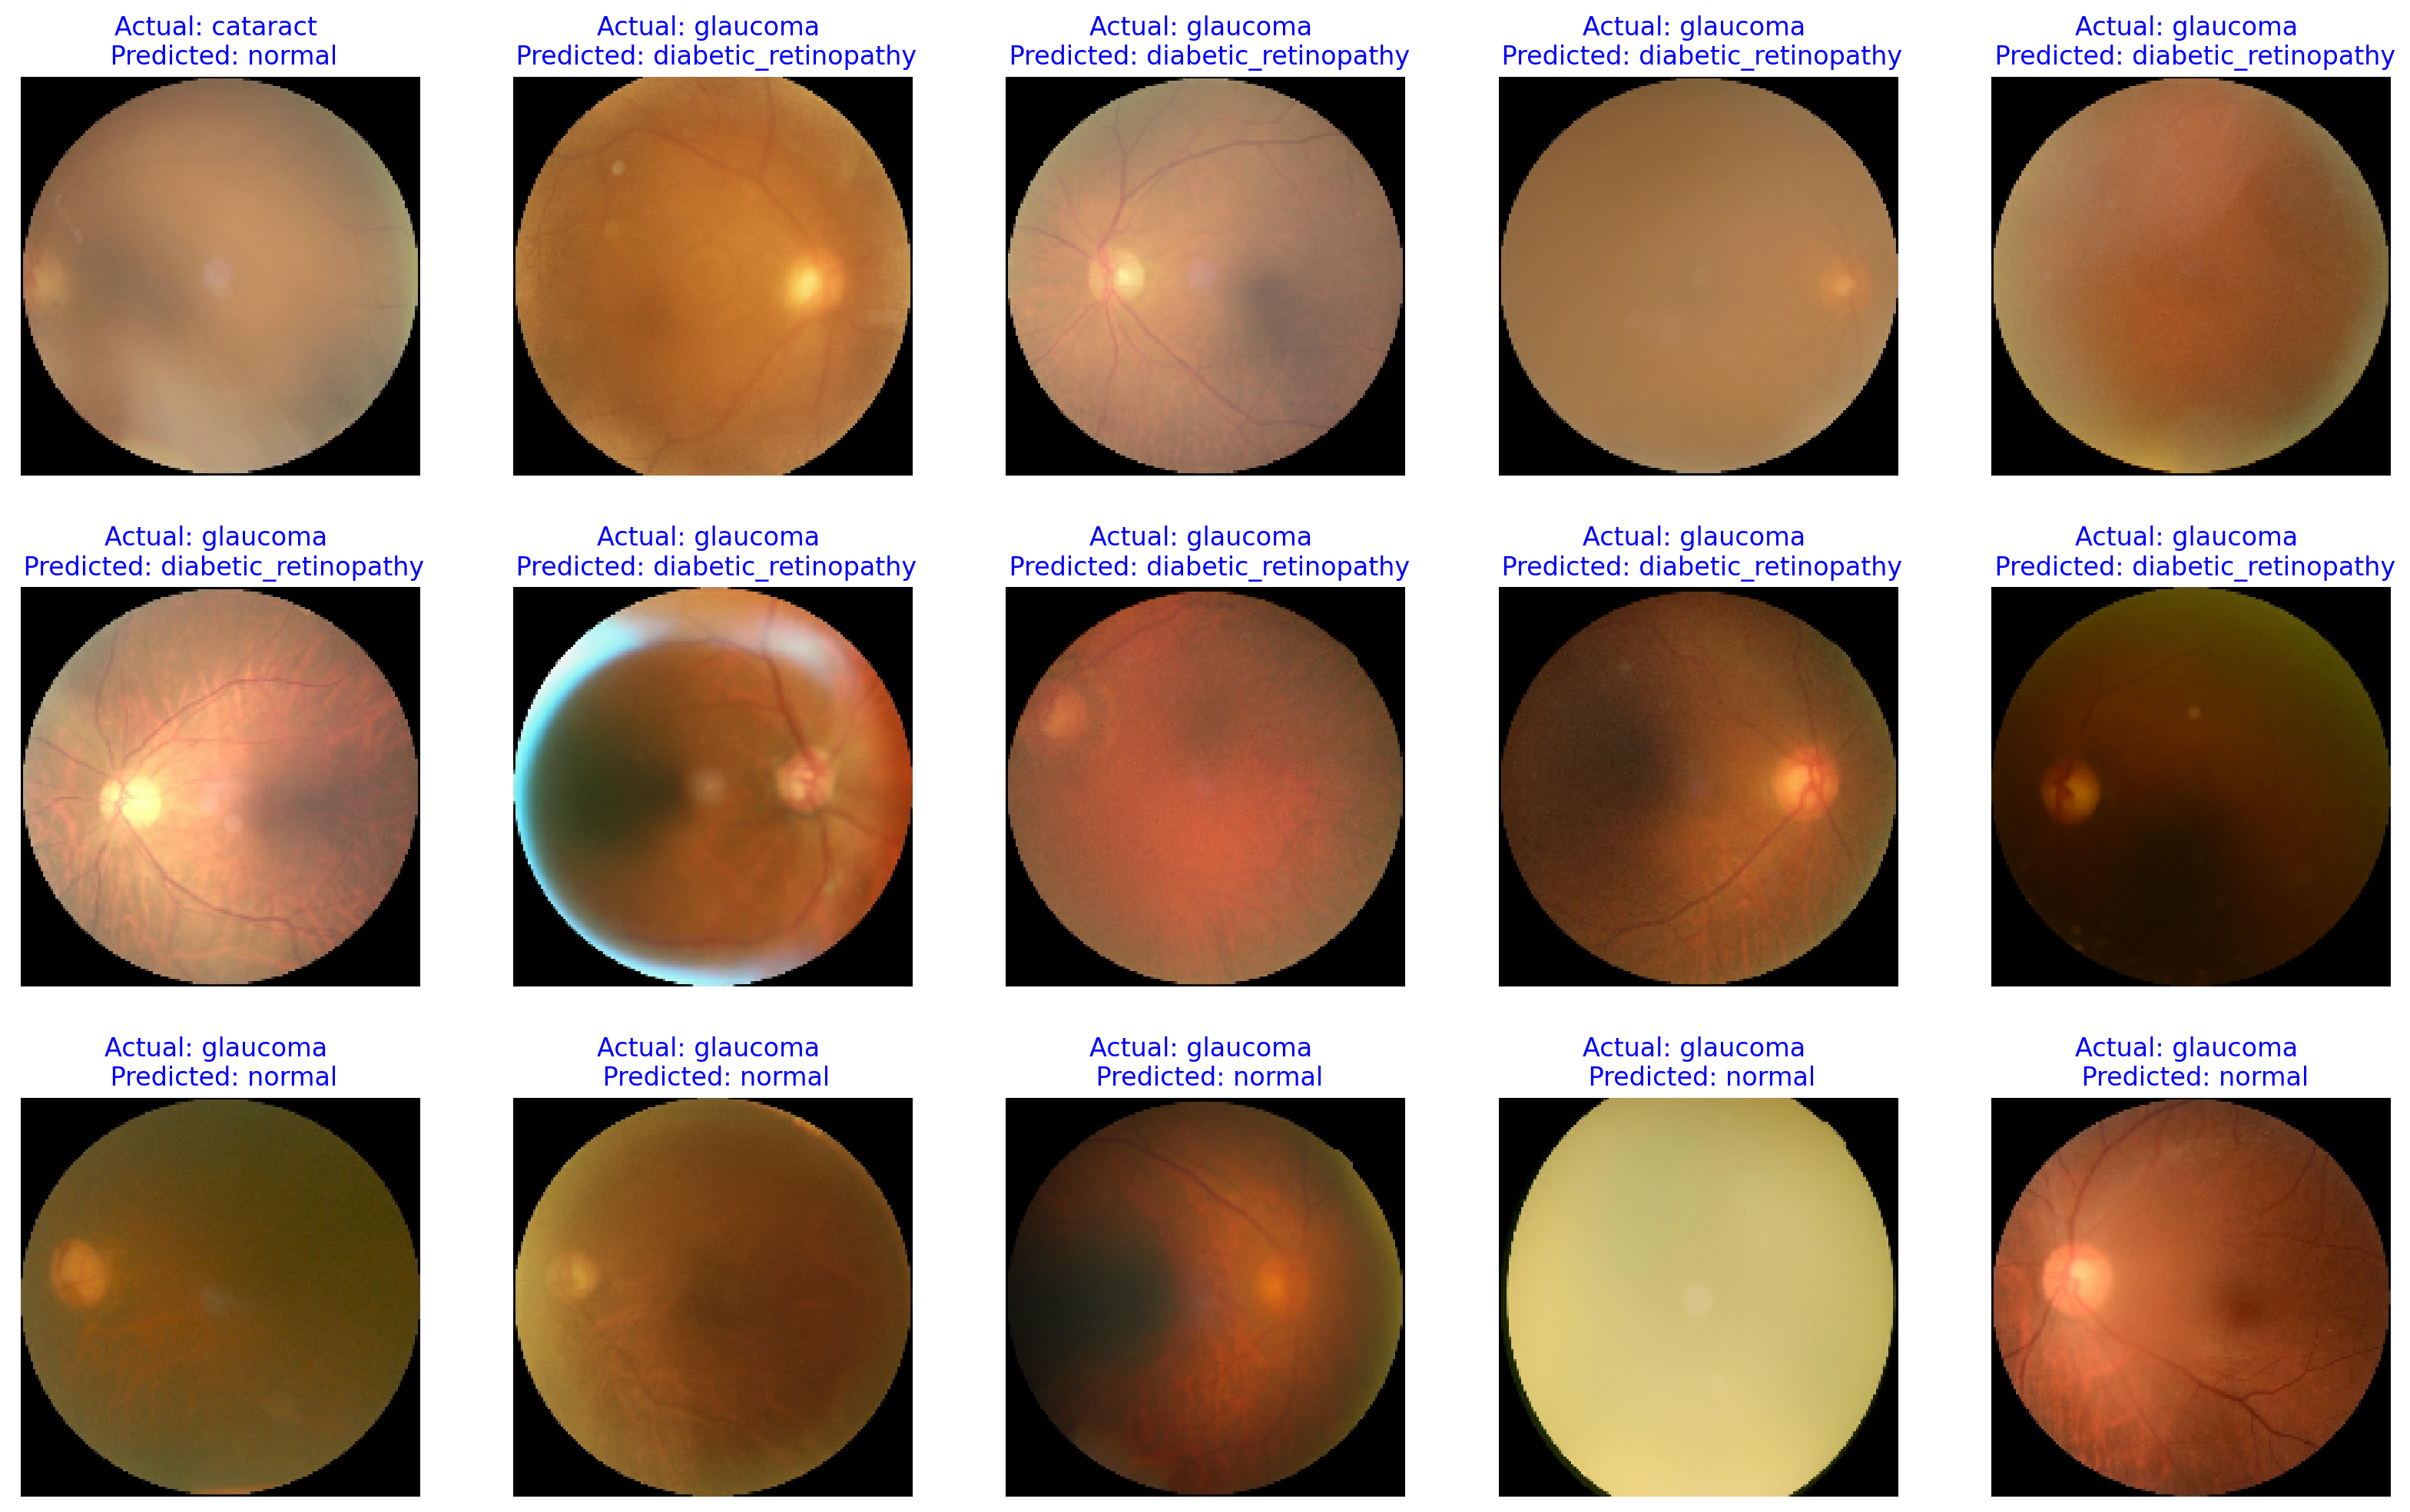

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a list called error_list containing (actual, predicted) pairs
# and test_images containing your test images

fig, axes = plt.subplots(3, 5, figsize=(20, 12)) # 3 rows, 5 cols

def axes_img(r, c, i):
    if i < len(error_list):
        axes[r, c].imshow(test_images[i].astype('uint8'))
        axes[r, c].axis('off')
        axes[r, c].set_title(f'Actual: {error_list[i][0]} \n Predicted: {error_list[i][1]}', color='blue')

# Loop through rows and columns to display images
for r in range(3):
    for c in range(5):
        i = r * 5 + c
        axes_img(r, c, i)

plt.subplots_adjust(hspace=0.28) # add space between rows
plt.show()
